# Final Project
Raymond Gu, Howard Cai


# Import Statements

In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings


warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

!unzip gdrive/My\ Drive/input.zip


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: input/train/audio/wow/da5dadb9_nohash_0.wav  
  inflating: input/train/audio/wow/da76aa58_nohash_0.wav  
  inflating: input/train/audio/wow/da76aa58_nohash_1.wav  
  inflating: input/train/audio/wow/da76aa58_nohash_2.wav  
  inflating: input/train/audio/wow/dabf67d9_nohash_0.wav  
  inflating: input/train/audio/wow/dabf67d9_nohash_1.wav  
  inflating: input/train/audio/wow/dabf67d9_nohash_2.wav  
  inflating: input/train/audio/wow/daf230ac_nohash_0.wav  
  inflating: input/train/audio/wow/db43cd03_nohash_0.wav  
  inflating: input/train/audio/wow/db72a474_nohash_0.wav  
  inflating: input/train/audio/wow/db79a764_nohash_0.wav  
  inflating: input/train/audio/wow/db7c95b0_nohash_0.wav  
  inflating: input/train/audio/wow/db9cd41d_nohash_0.wav  
  inflating: input/train/audio/wow/dbaf8fc6_nohash_0.wav  
  inflating: input/train/audio/wow/dbaf8fc6_nohash_1.wav  
  inflating: input/train/audio/wow/dbb40d24_nohash_0.wav  
  inflating: input/train/audi

# Preprocessing (only keep data of length of 1 sec)

In [3]:
train_audio_path = '../content/input/train/audio/'


labels=os.listdir(train_audio_path)

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

wow
bird
nine
cat
happy
up
stop
six
one
four
three
zero
dog
tree
marvin
no
_background_noise_
two
eight
five
right
left
down
house
bed
sheila
seven
go
off
on
yes


# Convert the output labels to integer

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(le.classes_)

['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


# Convert the integer encoded labels to a one-hot vector

In [5]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [6]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


# Spliting the data into training set and testing set

In [7]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

# Build the CNN model

In [8]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
print(inputs)

#First Conv1D layer
conv = Conv1D(8,15, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 13, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 8000, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7986, 8)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2650, 16)          1680      
                                            

# Compliing the Model

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# Training the model and save the best one

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [11]:
history=model.fit(x_tr, y_tr ,epochs=40, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Epoch 1/40
1457/1457 [==============================] - ETA: 0s - loss: 2.6589 - accuracy: 0.1961
Epoch 00001: val_accuracy improved from -inf to 0.41404, saving model to best_model.hdf5
1457/1457 [==============================] - 45s 22ms/step - loss: 2.6589 - accuracy: 0.1961 - val_loss: 1.8724 - val_accuracy: 0.4140
Epoch 2/40
1456/1457 [============================>.] - ETA: 0s - loss: 1.6329 - accuracy: 0.4891
Epoch 00002: val_accuracy improved from 0.41404 to 0.64381, saving model to best_model.hdf5
1457/1457 [==============================] - 29s 20ms/step - loss: 1.6327 - accuracy: 0.4892 - val_loss: 1.1612 - val_accuracy: 0.6438
Epoch 3/40
1454/1457 [============================>.] - ETA: 0s - loss: 1.2516 - accuracy: 0.6117
Epoch 00003: val_accuracy improved from 0.64381 to 0.70629, saving model to best_model.hdf5
1457/1457 [==============================] - 28s 19ms/step - loss: 1.2518 - accuracy: 0.6116 - val_loss: 0.9914 - val_accuracy: 0.7063
Epoch 4/40
1455/1457 [======

# Evaluating the model

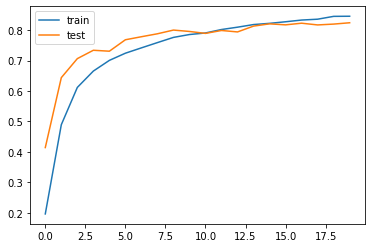

In [12]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
from keras.models import load_model
model=load_model('best_model.hdf5')

# Predict method

In [14]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]